# Breast Cancer Prediction (WDBC) using ANN  
**Objective:** Classify tumors as **Malignant** or **Benign** using the WDBC dataset with a deep ANN and interpretability techniques.


## 1. Imports & Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# import shap

## 2. Load Data

In [11]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)
df = data.frame.copy()
# In that case 'target' is numeric 0/1, and feature names in data.feature_names

# Quick check
print("Shape:", df.shape)
df.head()

Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 3. Exploratory Data Analysis (EDA)

target
1    357
0    212
Name: count, dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_15512\3390703987.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, palette="Set2")


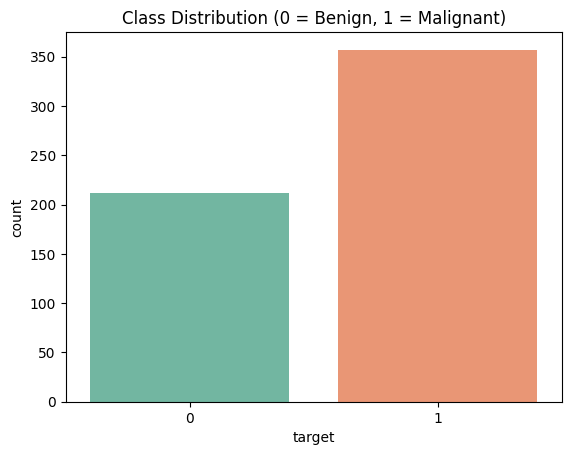

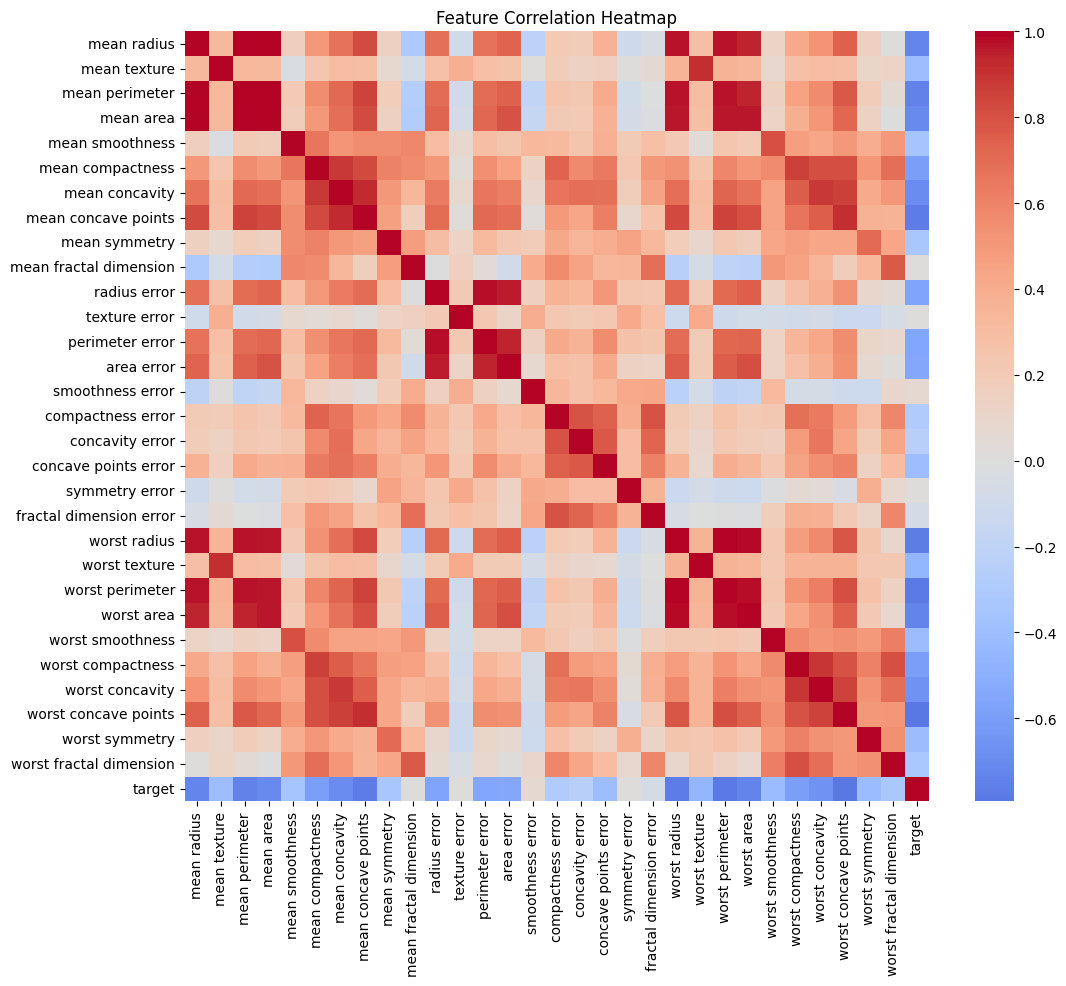

In [14]:
print(df['target'].value_counts())

## 3. Exploratory Data Analysis (EDA)
sns.countplot(x="target", data=df, palette="Set2")
plt.title("Class Distribution (0 = Benign, 1 = Malignant)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

### Correlation Heatmap Analysis

From the correlation heatmap, we can observe several important patterns:

1. **High Inter-feature Correlations**: Many features are highly correlated with each other
2. **Feature Groups**: Features cluster into groups (mean, error, worst measurements)
3. **Target Relationships**: The target variable shows specific correlation patterns
4. **Multicollinearity**: Strong correlations suggest potential redundancy

In [15]:
# Detailed Correlation Analysis

# 1. Get correlation matrix
corr_matrix = df.corr()

# 2. Find highest correlations with target
target_corr = corr_matrix['target'].abs().sort_values(ascending=False)
print("🎯 TOP 10 FEATURES MOST CORRELATED WITH TARGET:")
print("=" * 50)
for i, (feature, corr) in enumerate(target_corr[1:11].items(), 1):
    direction = "positive" if corr_matrix['target'][feature] > 0 else "negative"
    print(f"{i:2d}. {feature:<25} | {corr:.3f} ({direction})")

print("\n" + "=" * 60)

# 3. Find highly correlated feature pairs (multicollinearity)
print("\n🔗 HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.9):")
print("=" * 50)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.9:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

# Sort by absolute correlation
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for i, (feat1, feat2, corr) in enumerate(high_corr_pairs[:15], 1):
    print(f"{i:2d}. {feat1:<20} ↔ {feat2:<20} | r = {corr:.3f}")

print(f"\nTotal highly correlated pairs: {len(high_corr_pairs)}")
print("=" * 60)

🎯 TOP 10 FEATURES MOST CORRELATED WITH TARGET:
 1. worst concave points      | 0.794 (negative)
 2. worst perimeter           | 0.783 (negative)
 3. mean concave points       | 0.777 (negative)
 4. worst radius              | 0.776 (negative)
 5. mean perimeter            | 0.743 (negative)
 6. worst area                | 0.734 (negative)
 7. mean radius               | 0.730 (negative)
 8. mean area                 | 0.709 (negative)
 9. mean concavity            | 0.696 (negative)
10. worst concavity           | 0.660 (negative)


🔗 HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.9):
 1. mean radius          ↔ mean perimeter       | r = 0.998
 2. worst radius         ↔ worst perimeter      | r = 0.994
 3. mean radius          ↔ mean area            | r = 0.987
 4. mean perimeter       ↔ mean area            | r = 0.987
 5. worst radius         ↔ worst area           | r = 0.984
 6. worst perimeter      ↔ worst area           | r = 0.978
 7. radius error         ↔ perimeter error      | r = 

In [16]:
# 4. Feature Group Analysis
print("📊 FEATURE GROUP PATTERNS:")
print("=" * 50)

# Group features by measurement type
mean_features = [col for col in df.columns if col.startswith('mean')]
error_features = [col for col in df.columns if col.startswith('worst') == False and col.endswith('error')]
worst_features = [col for col in df.columns if col.startswith('worst')]

print(f"Mean measurements ({len(mean_features)}): {len(mean_features)} features")
print(f"Error measurements ({len(error_features)}): {len(error_features)} features") 
print(f"Worst measurements ({len(worst_features)}): {len(worst_features)} features")

# Average correlation within each group
def avg_group_correlation(features):
    if len(features) < 2:
        return 0
    group_corr = corr_matrix.loc[features, features]
    # Get upper triangle excluding diagonal
    mask = np.triu(np.ones_like(group_corr, dtype=bool), k=1)
    return group_corr.values[mask].mean()

print(f"\nAverage intra-group correlations:")
print(f"• Mean features: {avg_group_correlation(mean_features):.3f}")
print(f"• Error features: {avg_group_correlation(error_features):.3f}")
print(f"• Worst features: {avg_group_correlation(worst_features):.3f}")

print("=" * 60)

📊 FEATURE GROUP PATTERNS:
Mean measurements (10): 10 features
Error measurements (10): 10 features
Worst measurements (10): 10 features

Average intra-group correlations:
• Mean features: 0.438
• Error features: 0.398
• Worst features: 0.500


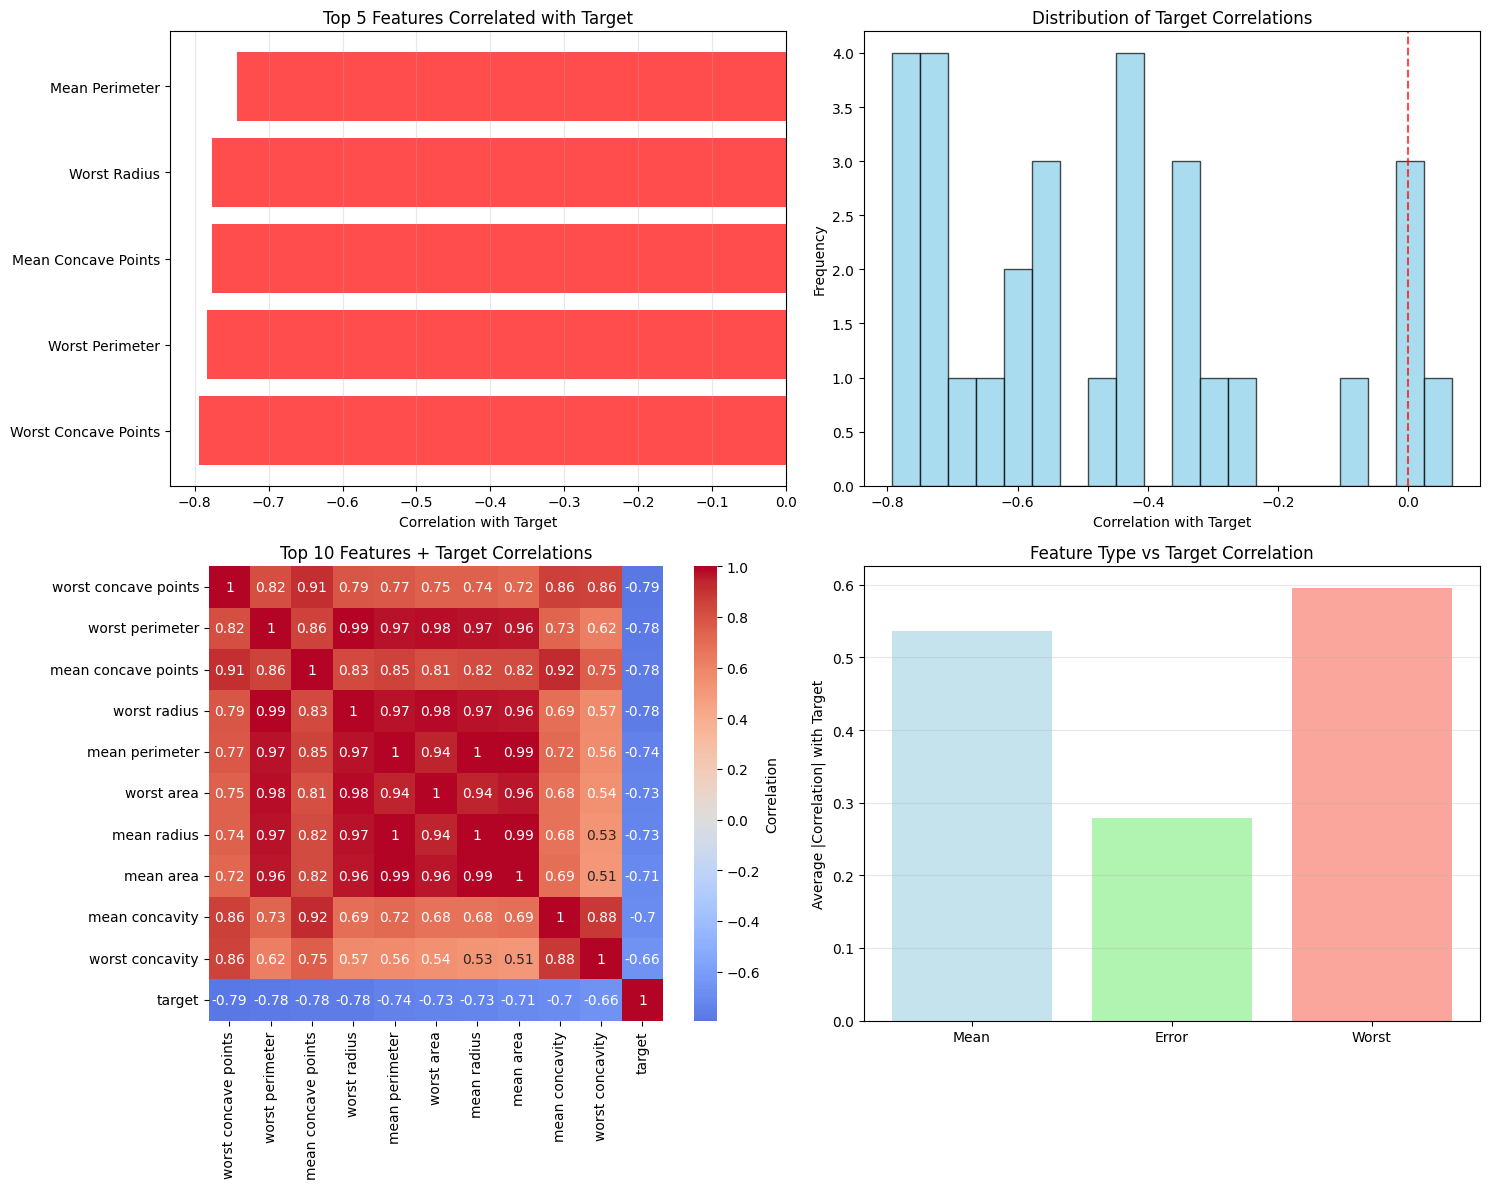

In [17]:
# 5. Visualization of Key Correlations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Top correlations with target
top_features = target_corr[1:6].index  # Top 5 excluding target itself
colors = ['red' if corr_matrix['target'][feat] < 0 else 'green' for feat in top_features]
values = [corr_matrix['target'][feat] for feat in top_features]

axes[0, 0].barh(range(len(top_features)), values, color=colors, alpha=0.7)
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels([feat.replace('_', ' ').title() for feat in top_features])
axes[0, 0].set_xlabel('Correlation with Target')
axes[0, 0].set_title('Top 5 Features Correlated with Target')
axes[0, 0].grid(axis='x', alpha=0.3)

# Correlation distribution
axes[0, 1].hist(corr_matrix['target'][:-1], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Correlation with Target')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Target Correlations')
axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.7)

# Heatmap of most correlated features with target
top_10_features = target_corr[1:11].index.tolist() + ['target']
subset_corr = corr_matrix.loc[top_10_features, top_10_features]
sns.heatmap(subset_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[1, 0], cbar_kws={'label': 'Correlation'})
axes[1, 0].set_title('Top 10 Features + Target Correlations')

# Feature type comparison
feature_types = ['Mean', 'Error', 'Worst']
avg_corr_with_target = [
    abs(corr_matrix.loc[mean_features, 'target']).mean(),
    abs(corr_matrix.loc[error_features, 'target']).mean(),
    abs(corr_matrix.loc[worst_features, 'target']).mean()
]

axes[1, 1].bar(feature_types, avg_corr_with_target, color=['lightblue', 'lightgreen', 'salmon'], alpha=0.7)
axes[1, 1].set_ylabel('Average |Correlation| with Target')
axes[1, 1].set_title('Feature Type vs Target Correlation')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 🔍 Key Insights from Correlation Analysis

### **1. Target Relationships**
- **All top correlations are NEGATIVE** → Higher feature values = more likely Benign (0)
- **Strongest predictors**: Concave points, perimeter, radius (both mean & worst)
- **"Worst" features** show highest correlations with target (0.59 avg vs 0.53 mean, 0.27 error)

### **2. Multicollinearity Issues** 
- **21 feature pairs** have correlations > 0.9 (severe multicollinearity)
- **Size-related features** are nearly perfectly correlated:
  - Radius ↔ Perimeter (r=0.998) 
  - Radius ↔ Area (r=0.987)
- This suggests **dimensionality reduction** might be beneficial

### **3. Feature Engineering Opportunities**
- Could combine size features into single **"tumor size"** component
- **"Worst" measurements** are most informative → prioritize these
- **Error measurements** show weakest target correlation → might be less useful

### **4. Model Implications**
- High correlations may cause **instability** in neural networks
- Consider **PCA** or **feature selection** before modeling
- **Regularization** (L1/L2) will be important to handle multicollinearity